In [1]:
import numpy as np 
import pandas as pd
import os
import string
from unidecode import unidecode
import dill
from IPython.display import Image as IPythonImage, display
from PIL import Image
import pytesseract
from Levenshtein import jaro_winkler
import matplotlib.pyplot as plt

In [2]:
validation_df = pd.read_csv("../input/handwriting-recognition/written_name_validation_v2.csv")
validation_df.head()

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


NAIS


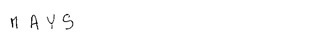

ELEONORE


PAUL


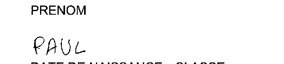

PILET


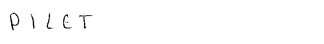

In [3]:
PATH = '../input/handwriting-recognition/validation_v2/validation'
NUMBER_OF_IMAGES = 4
random_index = np.random.choice(validation_df.shape[0], NUMBER_OF_IMAGES, False)
for row in validation_df.loc[random_index, :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(row.IDENTITY)
    display(IPythonImage(filename=filename))

In [4]:
output = {}
for row in validation_df.itertuples():
    file_path = os.path.join(PATH, row.FILENAME)
    image = Image.open(file_path)
    text = pytesseract.image_to_string(image)
    output[row.FILENAME] = text
    if ((row.Index + 1) % 5000) == 0:
        print(f"Processed {row.Index + 1} rows")

Processed 5000 rows
Processed 10000 rows
Processed 15000 rows
Processed 20000 rows
Processed 25000 rows
Processed 30000 rows
Processed 35000 rows
Processed 40000 rows


In [5]:
result_df = pd.DataFrame()
for i, (k, v) in enumerate(output.items()):
    if (i + 1) % 5000 == 0:
        print(f"Converted output from {i + 1} images")
    
    text = [t for t in v.split('\n') if t not in ['', ' ', '\n', '\x0c']]
    
    temp_df = pd.DataFrame({
        'FILENAME': [k] * len(text), 
        'TEXT': text
    })
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Look at the top 10 text tokens (these will probably be generic terms like "nom")
result_df['TEXT'].value_counts().nlargest(10)

Converted output from 5000 images
Converted output from 10000 images
Converted output from 15000 images
Converted output from 20000 images
Converted output from 25000 images
Converted output from 30000 images
Converted output from 35000 images
Converted output from 40000 images


PRENOM                      3231
NOM                         2742
                             765
Nom                          445
                             259
PRENOM.                      213
NOM:                         147
NOM :                        140
NoM                          106
DATE DE NAISSANCE CLASSE     100
Name: TEXT, dtype: int64

In [6]:
result_df\
    .loc[result_df['TEXT'].str.upper().str.contains('NOM|PRENOM|DATE DE NAISSANCE CLASSE') , "TEXT"]\
    .head(30)

10               RENOM: JERE AMY
12              sPRENOM: YUL: EN
14                  PRENOM: NACL
15                   NOM: BILGER
16                       PRENOM.
18     DATE DE NAISSANCE CLASSE.
21                          NOM:
24          PRENOM: Cf i € 374 y
30                           NOM
35                           NOM
37                          NOM:
41                  NOM: F9RivaT
50                           NOM
52                           NOM
61                RENOM: 1) XE b
66                           NOM
68                   Nom: DuBois
70                     NOM : NAW
76                        PRENOM
79                           NOM
86                           NOM
89                  NOM: = FAURE
92                           NOM
94                        PRENOM
99               NOM ; VAnNTOMUL
102                       PRENOM
104             |aqhENOM : LucAs
105                       PRENOM
107                          Nom
111                  NOM: DEBRRD
Name: TEXT

In [7]:
def filter_tokens(token_list, tokens_to_filter, remove_punctuation = True):
    # Punctuation and empty text
    punctuation_list = list(string.punctuation) + ['']
    result = []
    for t in token_list:
        # Remove stand-alone punctuation/empty string
        # Unicode has some fancy punctuation marks (slanting quotes, for example)
        # remove them using unidecode
        if remove_punctuation and unidecode(t) in punctuation_list:
            continue
        
        # Remove if any token in tokens_to_filter list is a substring of current token
        found = 0
        for t_filter in tokens_to_filter:
            if t_filter.upper() in t.upper():
                # token is matched in tokens_to_filter list
                found = 1
                break
        
        if found == 1:
            continue
        else:
            result.append(t)
    
    return result


# Define text to remove
SINGLE_TOKENS_REMOVE = ['NOM', 'PRENOM']
MULTI_TOKENS_REMOVE = ['DATE DE NAISSANCE CLASSE']

# Remove tokens
result_df['CLEAN_TEXT'] = result_df['TEXT']\
    .str\
    .split(' ')\
    .apply(lambda c: ' '.join(filter_tokens(c, SINGLE_TOKENS_REMOVE)))

for multi_token in MULTI_TOKENS_REMOVE:
    result_df['CLEAN_TEXT'] = np.where(result_df['CLEAN_TEXT'].str.contains(multi_token), 
                                       '', 
                                       result_df['CLEAN_TEXT'])

result_df.head(40)

,FILENAME,TEXT,CLEAN_TEXT
0,VALIDATION_0001.jpg,BiLeL,BiLeL
1,VALIDATION_0002.jpg,LAUMONIER,LAUMONIER
2,VALIDATION_0003.jpg,,
3,VALIDATION_0004.jpg,JTEAN-ROCH,JTEAN-ROCH
4,VALIDATION_0005.jpg,Ru er,Ru er
5,VALIDATION_0006.jpg,CODERNE/UAI; 0 642494 W,CODERNE/UAI; 0 642494 W
6,VALIDATION_0006.jpg,‘ne Sey 2,‘ne Sey 2
7,VALIDATION_0007.jpg,,
8,VALIDATION_0008.jpg,DAMI EL,DAMI EL
9,VALIDATION_0008.jpg,,


In [8]:
clean_result = result_df\
    .groupby('FILENAME')['CLEAN_TEXT']\
    .apply(''.join)\
    .reset_index()

clean_result.head(20)

,FILENAME,CLEAN_TEXT
0,VALIDATION_0001.jpg,BiLeL
1,VALIDATION_0002.jpg,LAUMONIER
2,VALIDATION_0003.jpg,
3,VALIDATION_0004.jpg,JTEAN-ROCH
4,VALIDATION_0005.jpg,Ru er
5,VALIDATION_0006.jpg,CODERNE/UAI; 0 642494 W‘ne Sey 2
6,VALIDATION_0007.jpg,
7,VALIDATION_0008.jpg,DAMI EL
8,VALIDATION_0009.jpg,JERE AMY
9,VALIDATION_0010.jpg,TEAN-Mic HEL


In [9]:
ocr_vs_actual = validation_df.merge(clean_result, how='left', on='FILENAME')

# Remove labels which do not exist
ocr_vs_actual = ocr_vs_actual.loc[ocr_vs_actual['IDENTITY'].notnull(), :]

# Remove spaces in OCR output
ocr_vs_actual['CLEAN_TEXT'] = ocr_vs_actual['CLEAN_TEXT'].str.replace('\\s', '', regex=True)
ocr_vs_actual.head(10)

,FILENAME,IDENTITY,CLEAN_TEXT
0,VALIDATION_0001.jpg,BILEL,BiLeL
1,VALIDATION_0002.jpg,LAUMIONIER,LAUMONIER
2,VALIDATION_0003.jpg,LEA,
3,VALIDATION_0004.jpg,JEAN-ROCH,JTEAN-ROCH
4,VALIDATION_0005.jpg,RUPP,Ruer
5,VALIDATION_0006.jpg,UNREADABLE,CODERNE/UAI;0642494W‘neSey2
6,VALIDATION_0007.jpg,PICHON,
7,VALIDATION_0008.jpg,DANIEL,DAMIEL
8,VALIDATION_0009.jpg,JEREMY,JEREAMY
9,VALIDATION_0010.jpg,JEAN-MICHEL,TEAN-MicHEL


In [10]:
vectorized_jaro_winkler = np.vectorize(jaro_winkler)

ocr_vs_actual['SIMILARITY_SCORE'] = vectorized_jaro_winkler(ocr_vs_actual['IDENTITY'].str.upper(), 
                                                            np.where(ocr_vs_actual['CLEAN_TEXT'].isnull(), 
                                                                     '', 
                                                                     ocr_vs_actual['CLEAN_TEXT'].str.upper()))
ocr_vs_actual.head(10)

,FILENAME,IDENTITY,CLEAN_TEXT,SIMILARITY_SCORE
0,VALIDATION_0001.jpg,BILEL,BiLeL,1.000000
1,VALIDATION_0002.jpg,LAUMIONIER,LAUMONIER,0.946667
2,VALIDATION_0003.jpg,LEA,,0.000000
3,VALIDATION_0004.jpg,JEAN-ROCH,JTEAN-ROCH,0.970000
4,VALIDATION_0005.jpg,RUPP,Ruer,0.733333
5,VALIDATION_0006.jpg,UNREADABLE,CODERNE/UAI;0642494W‘neSey2,0.440741
6,VALIDATION_0007.jpg,PICHON,,0.000000
7,VALIDATION_0008.jpg,DANIEL,DAMIEL,0.911111
8,VALIDATION_0009.jpg,JEREMY,JEREAMY,0.971429
9,VALIDATION_0010.jpg,JEAN-MICHEL,TEAN-MicHEL,0.939394


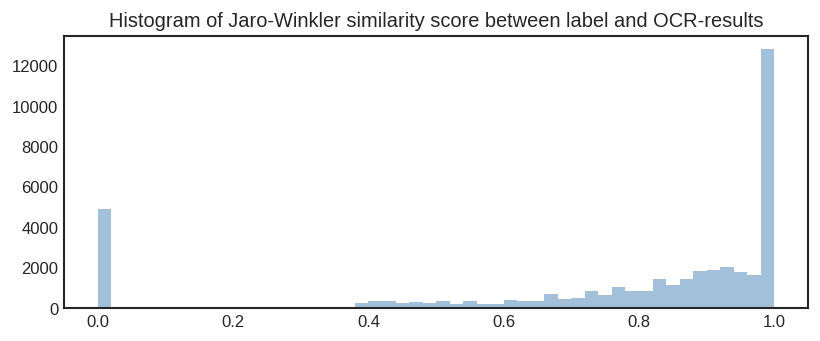

In [11]:
plt.style.use('seaborn-white')
plt.figure(figsize=(8,3), dpi=120)
plt.hist(ocr_vs_actual['SIMILARITY_SCORE'], bins=50, alpha=0.5, color='steelblue', edgecolor='none')
plt.title('Histogram of Jaro-Winkler similarity score between label and OCR-results')
plt.show()

In [12]:
second_lowest_score = ocr_vs_actual.loc[(ocr_vs_actual['SIMILARITY_SCORE'] != 0), 'SIMILARITY_SCORE'].min()

ocr_vs_actual['BINS'] = pd.cut(ocr_vs_actual['SIMILARITY_SCORE'], 
                               bins=[0] + np.linspace(second_lowest_score, 0.95, 9).tolist() + [0.96, 0.97, 0.98, 0.99, 1.01], 
                               labels = ['no-match', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'best-match'],
                               right=False)
ocr_vs_actual['BINS'].value_counts().sort_index()

no-match       4883
1               144
2               812
3              1388
4              1179
5              1747
6              2872
7              4858
8              8087
9               858
10              880
11              782
12              464
best-match    12338
Name: BINS, dtype: int64

Filename: VALIDATION_3406.jpg
Actual: ANNA
OCR: ANNA


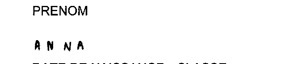

Filename: VALIDATION_4993.jpg
Actual: NOEMIE
OCR: NOEMIE


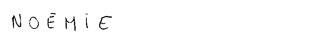

Filename: VALIDATION_28928.jpg
Actual: SOLANO
OCR: SOLANO


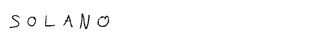

Filename: VALIDATION_32240.jpg
Actual: LOU-CARL
OCR: LOU-CARL


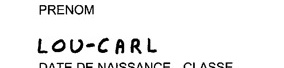

Filename: VALIDATION_40043.jpg
Actual: ARTHUR
OCR: ARTHUR


In [13]:
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == 'best-match', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))

Filename: VALIDATION_7716.jpg
Actual: JOURNE
OCR: TOURNE


Filename: VALIDATION_8272.jpg
Actual: THIBAUT
OCR: TheIBAUTaww


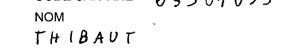

Filename: VALIDATION_18694.jpg
Actual: MOULIN
OCR: MOULIN“eehee


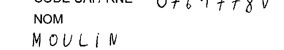

Filename: VALIDATION_29654.jpg
Actual: LOUIN
OCR: Lovin


Filename: VALIDATION_30102.jpg
Actual: THOMAS
OCR: Thowas


In [14]:
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == '8', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))

Filename: VALIDATION_5008.jpg
Actual: ELODIE
OCR: nan


Filename: VALIDATION_16019.jpg
Actual: DE-MUYT
OCR: nan


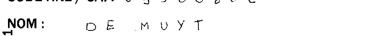

Filename: VALIDATION_18467.jpg
Actual: AIJ
OCR: CODERNE/UAIZO974659Heeelegee


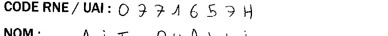

Filename: VALIDATION_19825.jpg
Actual: A
OCR: 


Filename: VALIDATION_34881.jpg
Actual: EMPTY
OCR: nan


In [15]:
NUMBER_OF_IMAGES = 5
random_filename = np.random.choice(ocr_vs_actual.loc[ocr_vs_actual['BINS'] == 'no-match', 'FILENAME'].tolist(), NUMBER_OF_IMAGES, False)
for row in ocr_vs_actual.loc[ocr_vs_actual['FILENAME'].isin(random_filename), :].itertuples(index=False):
    filename = os.path.join(PATH, row.FILENAME)
    print(f"""Filename: {row.FILENAME}\nActual: {row.IDENTITY}\nOCR: {row.CLEAN_TEXT}""")
    display(IPythonImage(filename=filename))